# **Classify Images based on *master category* label from *styles* dataframe**

# **Load Libraries**

In [1]:
pip install keras

In [2]:
pip install pillow # https://pypi.org/project/pillow/

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2  # OpenCV
from PIL import Image  # Pillow
from skimage.feature import hog, local_binary_pattern
import random
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# **EDA on Style Labels Data**

In [46]:
# Load labels of the images from styles.csv into a dataframe
df = pd.read_csv('data/styles.csv')

In [47]:
# 'id' in this dataframe represents the name of the image file (ex.49543.jpg; The 49543 is the id of the image in the dataframe)
df.sample(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
9034,35038,Women,Apparel,Topwear,Kurtas,Pink,Summer,2012.0,Ethnic,Fabindia Women Printed Pink Kurta
22368,13686,Women,Footwear,Flip Flops,Flip Flops,Yellow,Fall,2011.0,Casual,ADIDAS Women Adi Sunshine Flip Flops
3246,59095,Women,Apparel,Innerwear,Bra,Skin,Summer,2017.0,Casual,Peri Peri Women Skin Bra
5038,54385,Women,Accessories,Bags,Handbags,Yellow,Summer,2012.0,Casual,Baggit Women Yellow Sling Bag
5003,7103,Unisex,Accessories,Bags,Backpacks,Grey,Winter,2015.0,Casual,Wildcraft Unisex Grey Backpack


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44446 non-null  int64  
 1   gender              44446 non-null  object 
 2   masterCategory      44446 non-null  object 
 3   subCategory         44446 non-null  object 
 4   articleType         44446 non-null  object 
 5   baseColour          44431 non-null  object 
 6   season              44425 non-null  object 
 7   year                44445 non-null  float64
 8   usage               44129 non-null  object 
 9   productDisplayName  44439 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [49]:
# Missing values in Dataframe by percentage
df_missing = df.isnull().sum()/df.shape[0]*100
df_missing = df_missing.sort_values(ascending=False)
df_missing
#df_missing.plot.hist()

,0
usage,0.713225
season,0.047248
baseColour,0.033749
productDisplayName,0.015749
year,0.002250
id,0.000000
gender,0.000000
masterCategory,0.000000
subCategory,0.000000
articleType,0.000000


In [10]:
#Remove missing values even though the missing values percentage is very low and does not affect the classification
df = df.dropna(axis=0)

In [22]:
df.shape

(44099, 10)

In [11]:
# Dataframe: colour distribution by Gender
df_gender_colour = df.groupby(['gender','baseColour'])['gender'].count().reset_index(name='count')
df_gender_colour

,gender,baseColour,count
0,Boys,Beige,6
1,Boys,Black,83
2,Boys,Blue,159
3,Boys,Brown,10
4,Boys,Charcoal,1
...,...,...,...
157,Women,Taupe,11
158,Women,Teal,87
159,Women,Turquoise Blue,55
160,Women,White,1993


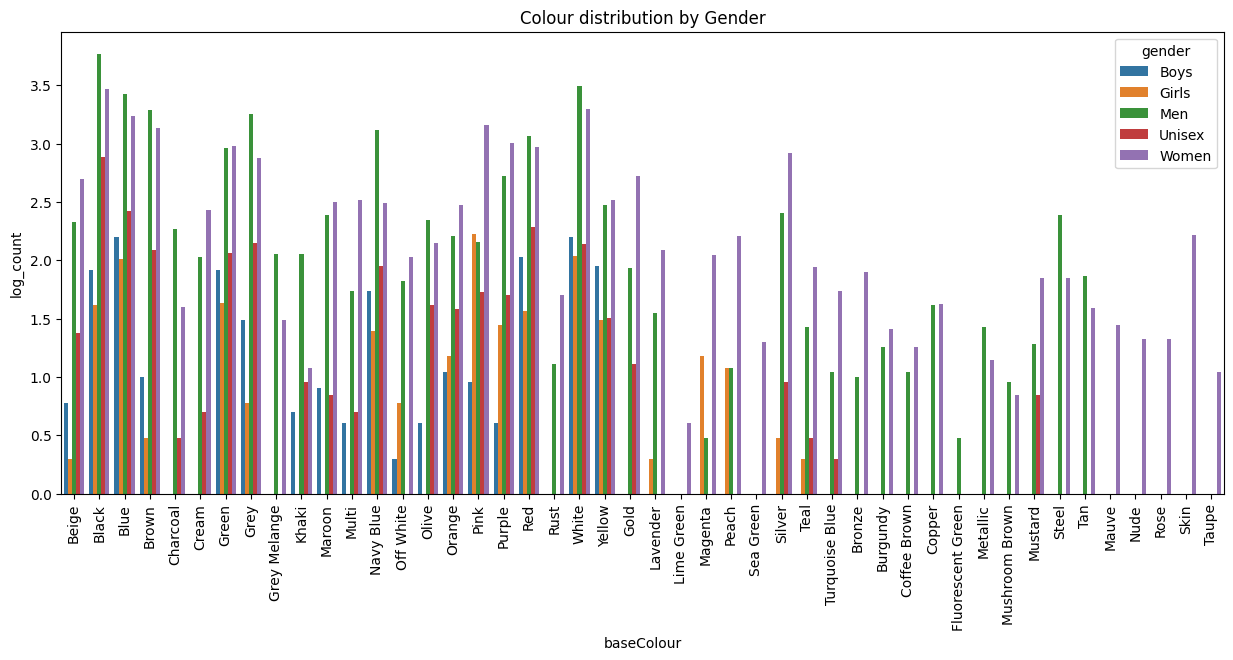

In [17]:
# Graphical representation of colour distribution by Gender
plt.figure(figsize=(15,6))
df_gender_colour['log_count'] = np.log10(df_gender_colour['count'])
#sns.histplot(x='baseColour', y='log_count', hue= 'gender', data=df_gender_colour)
sns.barplot(x='baseColour', y='log_count', hue= 'gender', data=df_gender_colour)
plt.title('Colour distribution by Gender')
plt.xticks(rotation=90)
plt.show()

In [13]:
# Images colour distribution by Master Category
df_master_category = df.groupby(['masterCategory','baseColour'])['masterCategory'].count().reset_index(name='count')
df_master_category

,masterCategory,baseColour,count
0,Accessories,Beige,202
1,Accessories,Black,3296
2,Accessories,Blue,712
3,Accessories,Bronze,29
4,Accessories,Brown,1306
...,...,...,...
192,Sporting Goods,Grey,1
193,Sporting Goods,Orange,2
194,Sporting Goods,Red,3
195,Sporting Goods,White,6


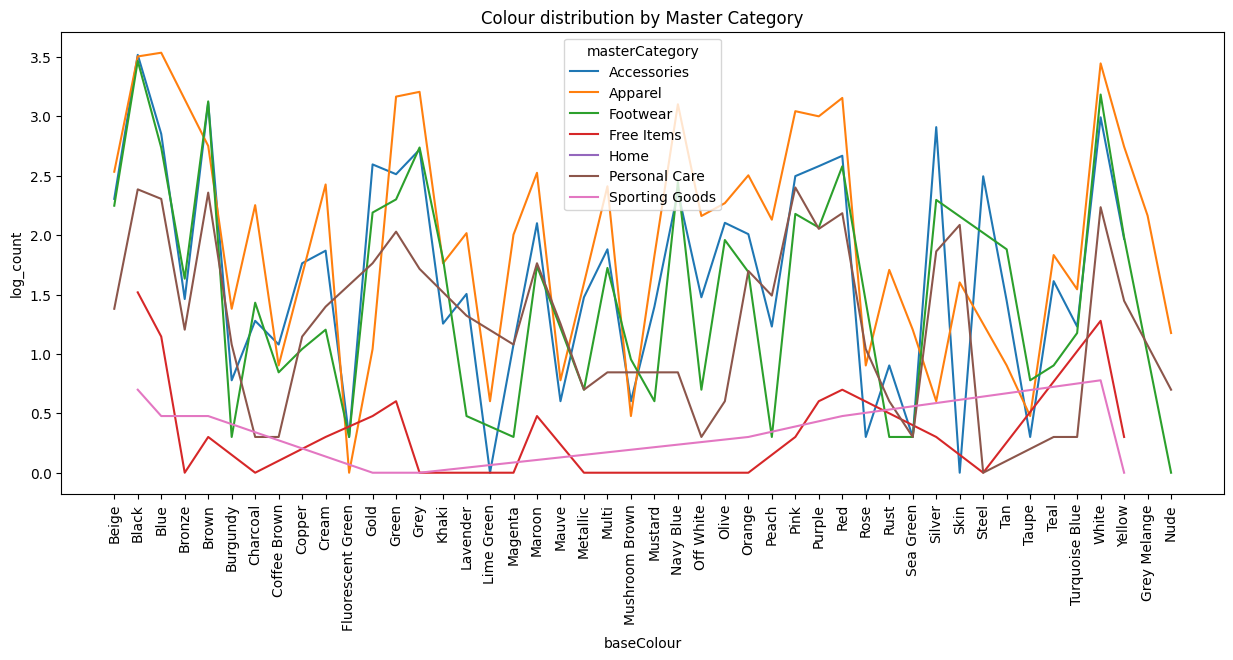

In [18]:
# Graphical representation of colour distribution by Master Category
plt.figure(figsize=(15,6))
df_master_category['log_count'] = np.log10(df_master_category['count'])
#sns.histplot(x='baseColour', y='log_count', hue= 'masterCategory', data=df_master_category)
sns.lineplot(x='baseColour', y='log_count', hue= 'masterCategory', data=df_master_category)
plt.title('Colour distribution by Master Category')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Images colour distribution by usage
df_usage = df.groupby(['usage','baseColour'])['usage'].count().reset_index(name='count')
df_usage

,usage,baseColour,count
0,Casual,Beige,581
1,Casual,Black,7474
2,Casual,Blue,3868
3,Casual,Bronze,88
4,Casual,Brown,2873
...,...,...,...
176,Travel,Brown,2
177,Travel,Green,6
178,Travel,Grey,2
179,Travel,Pink,1


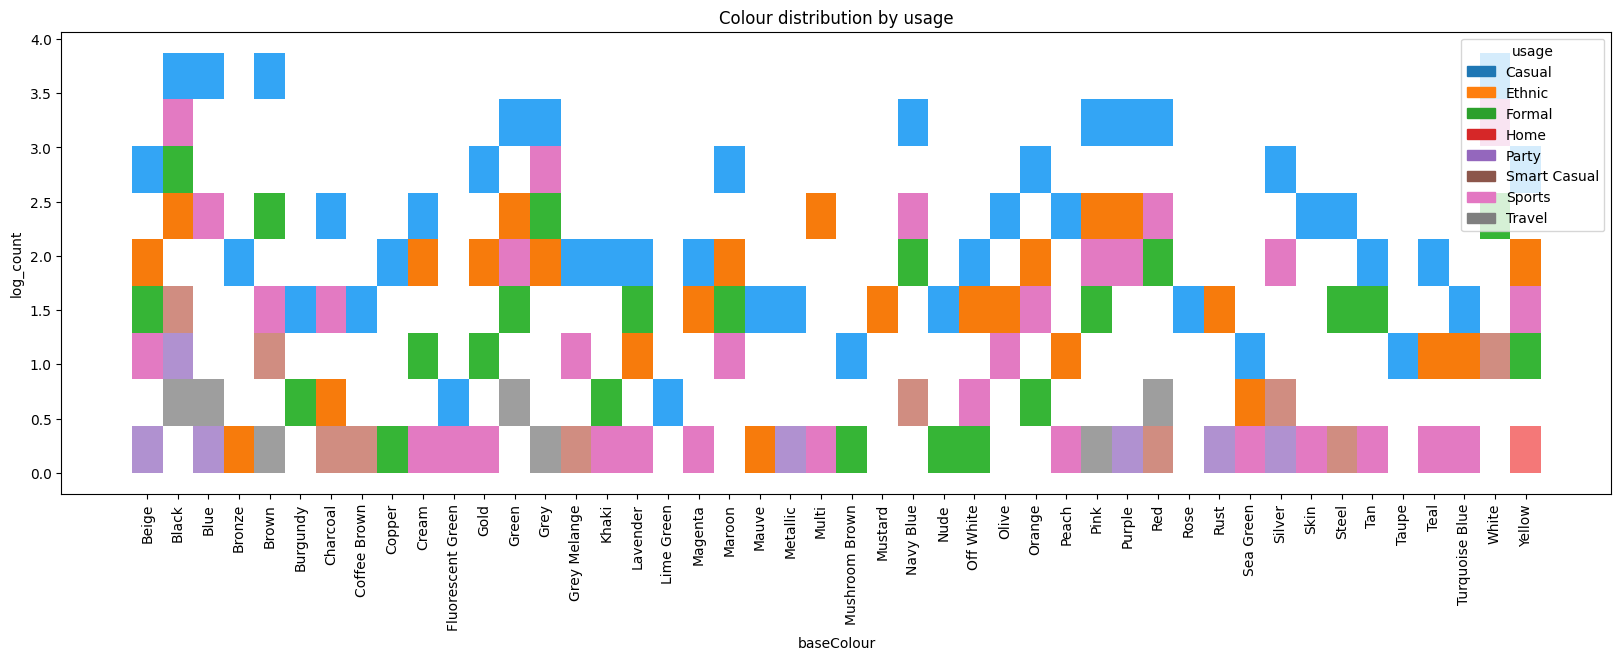

In [19]:
# Graphical representation of colour distribution by usage
plt.figure(figsize=(20,6))
df_usage['log_count'] = np.log10(df_usage['count'])
sns.histplot(x='baseColour', y='log_count', hue= 'usage', data=df_usage)
plt.title('Colour distribution by usage')
plt.xticks(rotation=90)
plt.show()

# **EDA on Images data**

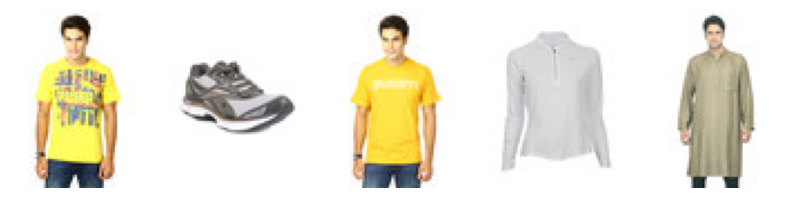

In [20]:
# Display sample pictures
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import load_img, img_to_array

# Function to display sample images
def display_sample_images(image_folder, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i, filename in enumerate(os.listdir(image_folder)[:num_samples]):
        img_path = os.path.join(image_folder, filename)
        img = load_img(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Display sample images
display_sample_images('images', num_samples=5)


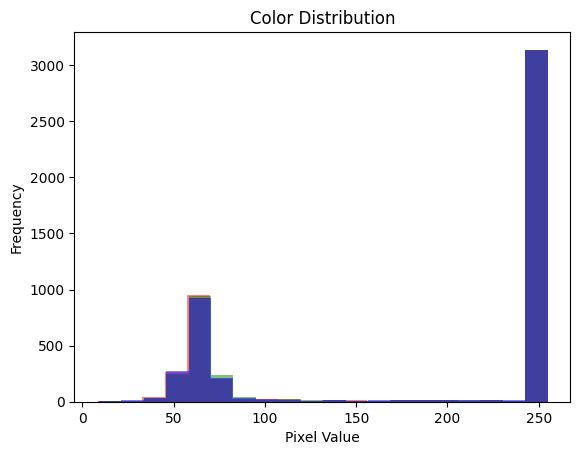

In [50]:
# Plot colour distribution of a sample image
def plot_color_distribution(image_folder, sample_image):
    img_path = os.path.join(image_folder, sample_image)
    img = img_to_array(load_img(img_path))
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        plt.hist(img[:, :, i].ravel(), bins=20, color=color, alpha=0.5)
    plt.title('Color Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot color distribution for a sample image
plot_color_distribution('images', '10004.jpg')  # Replace 'sample_image.jpg' with an actual image filename


# **Pre Processing of data: Images and Labels**

In [25]:
# Load images from the images folder
def load_images_from_folder(folder, img_size=(224, 224), df=None): # Pass the DataFrame to the function
    images = []
    labels = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            # Extract image ID from filename (assuming filename format: id_*.jpg)
            image_id = int(file.split('.')[0])

            # Get the corresponding 'masterCategory' from the DataFrame
            label = df.loc[df['id'] == image_id, 'masterCategory'].values[0]

            img_path = os.path.join(subdir, file)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load images, passing the DataFrame to get labels
folder = "images"
X, y = load_images_from_folder(folder, df=df) # Pass the DataFrame here

# Perform train-test split using the new 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Normalize image data
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (217, 224, 224, 3)
Testing data shape: (55, 224, 224, 3)


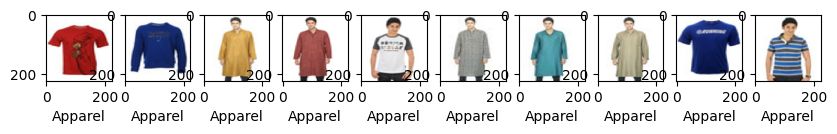

In [27]:
# 4. Sampling few images
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks()
    plt.yticks()
    plt.grid(False)
#    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.imshow(X_train[i], cmap=plt.cm.magma)
    plt.xlabel(y_train[i])
plt.show()

# **Modeling**

In [28]:
# Evaluate_model function:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Visualization (Seaborn)
    cm = confusion_matrix(y_test, y_pred)

    # Get unique class names from y_test and y_pred
    class_names_unique = np.unique(np.concatenate((y_test, y_pred)))

    cm_df = pd.DataFrame(cm, index=class_names_unique, columns=class_names_unique)  # Use unique class names
    print(f"{model_name} Confusion Matrix:")
    print(cm_df)

In [29]:
# Model1: SVM model
 # SVM with Raw Images (Reshaped)
# Reshape images for SVM (flatten)
x_train_reshaped = X_train.reshape(X_train.shape[0], -1)
x_test_reshaped = X_test.reshape(X_test.shape[0], -1)

svm_images = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_images.fit(x_train_reshaped, y_train)

SVC()

In [30]:
# Evaluate model1 (SVM performance)

evaluate_model(svm_images, x_test_reshaped, y_test, "SVM with Raw Images")

SVM with Raw Images Accuracy: 0.9636363636363636
              precision    recall  f1-score   support

 Accessories       0.00      0.00      0.00         1
     Apparel       0.98      0.98      0.98        48
    Footwear       0.86      1.00      0.92         6

    accuracy                           0.96        55
   macro avg       0.61      0.66      0.63        55
weighted avg       0.95      0.96      0.96        55

SVM with Raw Images Confusion Matrix:
             Accessories  Apparel  Footwear
Accessories            0        1         0
Apparel                0       47         1
Footwear               0        0         6


In [31]:
# Model2: KNN Model
# KNN classifier
# Train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train_reshaped, y_train)

KNeighborsClassifier(n_neighbors=3)

In [32]:
# Evalauate model2 (KNN performance)
evaluate_model(knn_model, x_test_reshaped, y_test, "KNN model evaluation")

KNN model evaluation Accuracy: 0.9818181818181818
              precision    recall  f1-score   support

 Accessories       0.00      0.00      0.00         1
     Apparel       0.98      1.00      0.99        48
    Footwear       1.00      1.00      1.00         6

    accuracy                           0.98        55
   macro avg       0.66      0.67      0.66        55
weighted avg       0.96      0.98      0.97        55

KNN model evaluation Confusion Matrix:
             Accessories  Apparel  Footwear
Accessories            0        1         0
Apparel                0       48         0
Footwear               0        0         6


In [33]:
# Model3: RandomForest model
# RandomForest classifier
# Train a RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_reshaped, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# Evalauate model3 (RandomForest performance)
# Evalauate RandomForest model
evaluate_model(rf_model, x_test_reshaped, y_test, "RandomForest model evaluation")

RandomForest model evaluation Accuracy: 0.9636363636363636
              precision    recall  f1-score   support

 Accessories       0.00      0.00      0.00         1
     Apparel       0.98      0.98      0.98        48
    Footwear       0.86      1.00      0.92         6

    accuracy                           0.96        55
   macro avg       0.61      0.66      0.63        55
weighted avg       0.95      0.96      0.96        55

RandomForest model evaluation Confusion Matrix:
             Accessories  Apparel  Footwear
Accessories            0        1         0
Apparel                0       47         1
Footwear               0        0         6


# **HyperParameter Tuning and GridSearachCV**

**The step execution takes long time atleast 20 minutes for 500+ images, so plan accordingly to run.**

In [35]:
# Only SVC, KNN, RandormForest are being selected. GradientBoosting was excluded as it is taking lot longer time to train the images.
# Define the parameter grid for each model
param_grid = {
    'SVC': {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

# Create a dictionary to store the models
models = {
    'SVC': SVC(),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier()
}

# Create a dictionary to store the best models and parameters
best_models = {}

# Perform GridSearchCV for each model
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='accuracy')
    grid_search.fit(x_train_reshaped, y_train)  # Use your training data here

    best_models[model_name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_,
        'score': grid_search.best_score_
    }

# Print the best model and parameters for each algorithm
for model_name, results in best_models.items():
    print(f"Best {model_name}:")
    print(f"  Parameters: {results['params']}")
    print(f"  Score: {results['score']}")


# Evaluate the best models on the test set
for model_name, results in best_models.items():
  evaluate_model(results['model'], x_test_reshaped, y_test, f"Best {model_name}")


Best SVC:
  Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
  Score: 0.9862579281183933
Best KNN:
  Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
  Score: 0.9817124735729387
Best RandomForest:
  Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
  Score: 0.9724101479915432
Best SVC Accuracy: 0.9636363636363636
              precision    recall  f1-score   support

 Accessories       0.00      0.00      0.00         1
     Apparel       0.98      0.98      0.98        48
    Footwear       1.00      1.00      1.00         6

    accuracy                           0.96        55
   macro avg       0.66      0.66      0.66        55
weighted avg       0.96      0.96      0.96        55

Best SVC Confusion Matrix:
             Accessories  Apparel  Footwear
Accessories            0        1         0
Apparel                1       47         0
Footwear               0        0         6
Best KNN Accuracy: 0.98181818181818

# **OpenCV** - Model performance evaluation using OpenCV, HOG, LBP via features extraction

In [36]:
# 6. Feature Extraction (Pillow/OpenCV, with Texture)
def extract_features(images):
     # Initialize an empty list to store features
    features = []
    for image in images:

        # Color Histogram (using OpenCV)
        if len(image.shape) == 3:  # If the image has 3 channels (RGB/BGR)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        image = image.astype(np.uint8)
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])  # Correct syntax for calcHist
        hist = hist.flatten()

        # HOG (Histogram of Oriented Gradients) - Texture
        hog_features, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),
                                      cells_per_block=(2, 2), visualize=True)

        # LBP (Local Binary Patterns) - Texture
        radius = 1
        n_points = 8 * radius
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 2), range=(0, n_points + 1))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-7)

        # Combine all features into a single array
        image_features = np.concatenate([hist, hog_features, lbp_hist])
        features.append(image_features)

    return np.array(features)

In [37]:
# Add feature for the Xtrain and Xtest

x_train_features = extract_features(X_train)
x_test_features = extract_features(X_test)

In [38]:
# 7. Feature Scaling (NumPy):
scaler = StandardScaler()
x_train_features_scaled = scaler.fit_transform(x_train_features)  # Input and output are NumPy arrays
x_test_features_scaled = scaler.transform(x_test_features)

In [39]:
# OpenCV : SVM with Extracted Features
svm_features = SVC(kernel='linear', C=0.1, gamma='scale') # Updated parameters as per the GridSearchCV in previous steps
svm_features.fit(x_train_features_scaled, y_train)

SVC(C=0.1, kernel='linear')

In [40]:
# Evaluate OpenCV with SVM model

evaluate_model(svm_features, x_test_features_scaled, y_test, "SVM with Features")

SVM with Features Accuracy: 0.9818181818181818
              precision    recall  f1-score   support

 Accessories       0.00      0.00      0.00         1
     Apparel       0.98      1.00      0.99        48
    Footwear       1.00      1.00      1.00         6

    accuracy                           0.98        55
   macro avg       0.66      0.67      0.66        55
weighted avg       0.96      0.98      0.97        55

SVM with Features Confusion Matrix:
             Accessories  Apparel  Footwear
Accessories            0        1         0
Apparel                0       48         0
Footwear               0        0         6


# **Pillow** - Model performance evaluation using Pillow and RandomForest

In [41]:
# Assuming you have a directory named 'images' with subdirectories for each class.

def load_images_from_folder(folder, img_size=(224, 224), df=None): # Pass the DataFrame to the function
    images = []
    labels = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            # Extract image ID from filename (assuming filename format: id_*.jpg)
            image_id = int(file.split('.')[0])

            # Get the corresponding 'masterCategory' from the DataFrame
            label = df.loc[df['id'] == image_id, 'masterCategory'].values[0]
            image_path = os.path.join(subdir, file)

            try:
                img = Image.open(image_path).convert('RGB') # convert to RGB
                img = img.resize((64, 64)) # resize to a consistent size
                img_array = np.array(img).flatten() # flatten the image array
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                 print(f"Error loading image {image_path}: {e}")
    return np.array(images), np.array(labels)

# Load images, passing the DataFrame to get labels
folder = "images"
X, y = load_images_from_folder(folder, df=df) # Pass the DataFrame here

# Perform train-test split using the new 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
#clf = SVC(kernel='linear') # you can change the kernel
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9818181818181818
              precision    recall  f1-score   support

 Accessories       0.00      0.00      0.00         1
     Apparel       0.98      1.00      0.99        48
    Footwear       1.00      1.00      1.00         6

    accuracy                           0.98        55
   macro avg       0.66      0.67      0.66        55
weighted avg       0.96      0.98      0.97        55

[[ 0  1  0]
 [ 0 48  0]
 [ 0  0  6]]


In [42]:
# Evalauate Pillow model
evaluate_model(clf, X_test, y_test, "RandomForest with Pillow")

RandomForest with Pillow Accuracy: 0.9818181818181818
              precision    recall  f1-score   support

 Accessories       0.00      0.00      0.00         1
     Apparel       0.98      1.00      0.99        48
    Footwear       1.00      1.00      1.00         6

    accuracy                           0.98        55
   macro avg       0.66      0.67      0.66        55
weighted avg       0.96      0.98      0.97        55

RandomForest with Pillow Confusion Matrix:
             Accessories  Apparel  Footwear
Accessories            0        1         0
Apparel                0       48         0
Footwear               0        0         6


## **Pillow package prediction is perfect with few or no false positives. It classified images correctly. See the confusion matrix**

# **Update DataFrame with Predicted Label for *master category* for comparision**

In [43]:
# Create a new column in your DataFrame for model predictions
df['model_predicted_masterCategory'] = None  # Initialize with None

# Function to predict masterCategory for images in a directory
def predict_masterCategory(image_dir, model, df):
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
            image_id = int(filename.split('.')[0])  # Extract image ID from filename
            image_path = os.path.join(image_dir, filename)

            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((64, 64))
                img_array = np.array(img).flatten()
                prediction = model.predict([img_array])  # Predict using trained model

                # Update the DataFrame with predictions
                df.loc[df['id'] == image_id, 'model_predicted_masterCategory'] = prediction[0]

            except Exception as e:
                print(f"Error processing image {filename}: {e}")

# Call the function to predict and update the DataFrame
predict_masterCategory("images", clf, df)


In [44]:
# Show only df with updated rows only
df = df.dropna(subset=['model_predicted_masterCategory'])
# Print the updated DataFrame to verify
print(df.sample(10))

          id gender masterCategory subCategory articleType baseColour  season  \
9010   30778    Men        Apparel     Topwear      Kurtas      Green  Summer   
31427   9944    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
7973    9948    Men        Apparel     Topwear     Tshirts      White    Fall   
37296   9768    Men        Apparel     Topwear     Jackets      Black    Fall   
4109   10064    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
27046  10051    Men        Apparel     Topwear      Shirts  Navy Blue    Fall   
38069  30734    Men        Apparel  Bottomwear    Churidar      White  Summer   
33590  30759    Men        Apparel     Topwear      Kurtas      Black  Summer   
6802    9778    Men        Apparel     Topwear     Tshirts      White    Fall   
28931   9974    Men        Apparel     Topwear     Tshirts      Black    Fall   

         year   usage                       productDisplayName  \
9010   2012.0  Ethnic           Fabindia M

# **Plotting the results to show model accuracy. Actual vs Predicted values of Master Category**

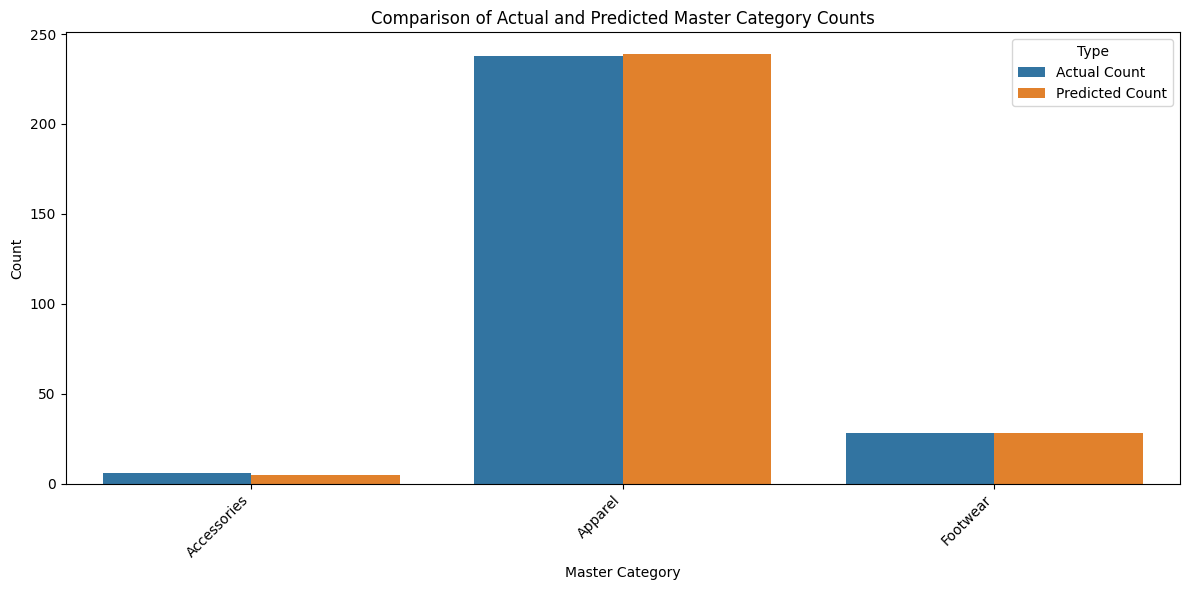

In [45]:
# Count occurrences of masterCategory and model_predicted_masterCategory
master_category_counts = df['masterCategory'].value_counts().reset_index()
predicted_master_category_counts = df['model_predicted_masterCategory'].value_counts().reset_index()

# Rename columns for merging
master_category_counts.columns = ['Category', 'Actual Count']
predicted_master_category_counts.columns = ['Category', 'Predicted Count']

# Merge the dataframes
plot_df = pd.merge(master_category_counts, predicted_master_category_counts, on='Category', how='outer').fillna(0)

# Melt the dataframe for easier plotting with seaborn
plot_df_melted = pd.melt(plot_df, id_vars=['Category'], value_vars=['Actual Count', 'Predicted Count'], var_name='Type', value_name='Count')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Count', hue='Type', data=plot_df_melted)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Master Category')
plt.ylabel('Count')
plt.title('Comparison of Actual and Predicted Master Category Counts')
plt.tight_layout()
plt.show()


# **Next Steps:**

## 1) Perform model fit on even larger dataset

## 2) Enhance the modelling using CNN, Transfer Learning etc.

## 3) Enhance modelling if we can extract additional features from the images while processing the classification

## 4) Feed a brand new dataset outside of that used train/test to test the accuracy of model